In [1]:
import os
import numpy as np

import fitsio
import matplotlib.pyplot as plt

from desisim.scripts import quickgen
from desispec.io.brick import Brick

%matplotlib inline

In [2]:
outdir = os.path.join(os.getenv('HOME'), 'simlens')
print(outdir)

/home/desi1/simlens


In [8]:
brickname = 'lens01'
simargs = ['--brickname', brickname,
           '--nspec', '3',
           '--exptime', '15000',
           '--outdir', outdir,
           '--objtype', 'ELG']
args = quickgen.parse(simargs)
args

Namespace(add_SNeIa=False, airmass=1.25, brickname='lens01', config='desi', exptime=15000.0, fibermap=None, frameonly=False, moon_angle=None, moon_phase=None, moon_zenith=None, nspec=3, nstart=0, objtype='ELG', outdir='/home/desi1/simlens', outdir_truth=None, rmagrange_bgs=(15.0, 19.5), seed=0, simspec=None, sne_rfluxratiorange=(0.1, 1.0), spectrograph=None, verbose=False, zrange_bgs=(0.01, 0.4), zrange_elg=(0.6, 1.6), zrange_lrg=(0.5, 1.1), zrange_qso=(0.5, 4.0))

In [9]:
# Generate the spectra.
quickgen.main(args)

INFO:quickgen.py:275:main: Initializing SpecSim with config desi
INFO:quickgen.py:329:main: Generating ELG template
INFO:io.py:606:read_basis_templates: Reading /global/work/desi/spectro/templates/basis_templates/v2.2/elg_templates_v2.0.fits
HEY!!!!!!!!!!!!!!!!!!!!!!!!!!!! Exptime 15000.0 s
INFO:quickgen.py:659:main: Wrote file /home/desi1/simlens/brick-b-lens01.fits


INFO:quickgen.py:659:main: Wrote file /home/desi1/simlens/brick-r-lens01.fits
INFO:quickgen.py:659:main: Wrote file /home/desi1/simlens/brick-z-lens01.fits


In [10]:
# Poke around the brick files.
camera = 'r'
rfile = os.path.join(outdir, 'brick-{}-{}.fits'.format(camera, brickname))
rr = fitsio.FITS(rfile)
rr


  file: /home/desi1/simlens/brick-r-lens01.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       FLUX
  1      IMAGE_HDU       IVAR
  2      IMAGE_HDU       WAVELENGTH
  3      IMAGE_HDU       RESOLUTION
  4      BINARY_TBL      FIBERMAP
  5      IMAGE_HDU       _TRUEFLUX

In [11]:
# Grab the spectra.
wave = []
flux = []
fivar = []
trueflux = []

for camera in ('b', 'r', 'z'):
    brickfile = os.path.join(outdir, 'brick-{}-{}.fits'.format(camera, brickname))
    print(brickfile)
    brick = Brick(brickfile)
    
    wave1, flux1, fivar1, trueflux1 = brick.hdu_list[2].data, brick.hdu_list[0].data, brick.hdu_list[1].data, brick.hdu_list[5].data
    print(flux1.shape)

    wave.append(wave1)
    flux.append(flux1)
    fivar.append(fivar1)
    trueflux.append(trueflux1) 


/home/desi1/simlens/brick-b-lens01.fits
(3, 4760)
/home/desi1/simlens/brick-r-lens01.fits
(3, 4232)
/home/desi1/simlens/brick-z-lens01.fits
(3, 4798)


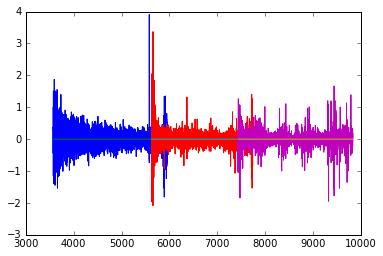

In [15]:
objindx = 0

for ii in (0, 1, 2):
    plt.plot(wave[ii], flux[ii][objindx, :])
    plt.plot(wave[ii], trueflux[ii][objindx, :])